In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [3]:
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [58]:
# Load data
ratings = pd.read_csv(r"D:\\New folder (2)\\pranthi\\code tech it\\rating.csv")

In [59]:
# Factorize userId and movieId
ratings['user_index'], _ = pd.factorize(ratings['userId'])
ratings['movie_index'], _ = pd.factorize(ratings['movieId'])


In [60]:
num_users = ratings['user_index'].nunique()
num_movies = ratings['movie_index'].nunique()


In [61]:
# Train-test split
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

In [31]:
# ✅ PyTorch Dataset
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_index'].values, dtype=torch.long)
        self.movies = torch.tensor(df['movie_index'].values, dtype=torch.long)
        self.ratings_tensor = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings_tensor)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings_tensor[idx]


In [32]:
train_dataset = RatingsDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True, num_workers=0)


In [33]:
# ✅ Matrix Factorization Model
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, latent_dim):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.movie_embedding = nn.Embedding(num_movies, latent_dim)

    def forward(self, user_ids, movie_ids):
        user_vecs = self.user_embedding(user_ids)
        movie_vecs = self.movie_embedding(movie_ids)
        dot = (user_vecs * movie_vecs).sum(1)
        return dot

In [34]:
# ✅ Instantiate model
latent_dim = 128
model = MatrixFactorization(num_users, num_movies, latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [35]:
# ✅ Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for user_batch, movie_batch, rating_batch in train_loader:
        user_batch = user_batch.to(device)
        movie_batch = movie_batch.to(device)
        rating_batch = rating_batch.to(device)

        optimizer.zero_grad()
        outputs = model(user_batch, movie_batch)
        loss = criterion(outputs, rating_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"📘 Epoch {epoch+1}/{epochs} - Loss: {epoch_loss / len(train_loader):.4f}")

    if torch.cuda.is_available():
        print("   GPU Memory Allocated:", torch.cuda.memory_allocated() / 1024**2, "MB")

📘 Epoch 1/10 - Loss: 105.1406
   GPU Memory Allocated: 324.7001953125 MB
📘 Epoch 2/10 - Loss: 55.6604
   GPU Memory Allocated: 324.7001953125 MB
📘 Epoch 3/10 - Loss: 33.4663
   GPU Memory Allocated: 324.7001953125 MB
📘 Epoch 4/10 - Loss: 20.8208
   GPU Memory Allocated: 324.7001953125 MB
📘 Epoch 5/10 - Loss: 10.1552
   GPU Memory Allocated: 324.7001953125 MB
📘 Epoch 6/10 - Loss: 4.9983
   GPU Memory Allocated: 324.7001953125 MB
📘 Epoch 7/10 - Loss: 2.9535
   GPU Memory Allocated: 324.7001953125 MB
📘 Epoch 8/10 - Loss: 1.9628
   GPU Memory Allocated: 324.7001953125 MB
📘 Epoch 9/10 - Loss: 1.4338
   GPU Memory Allocated: 324.7001953125 MB
📘 Epoch 10/10 - Loss: 1.1368
   GPU Memory Allocated: 324.7001953125 MB


In [36]:
# ✅ Save model
torch.save(model.state_dict(), "matrix_factorization_model.pth")
print("✅ Model saved to 'matrix_factorization_model.pth'")


✅ Model saved to 'matrix_factorization_model.pth'


In [37]:
# ✅ Load model (example)
model_loaded = MatrixFactorization(num_users, num_movies, latent_dim).to(device)
model_loaded.load_state_dict(torch.load("matrix_factorization_model.pth"))
model_loaded.eval()
print("✅ Model reloaded successfully")


✅ Model reloaded successfully


C:\Users\susha\AppData\Local\Temp\ipykernel_6888\576904941.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load("matrix_factorization_

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch


In [43]:
# Function to predict ratings and classify as binary (liked/disliked)
def predict_and_classify(user_batch, movie_batch, rating_batch, threshold=3.0):
    user_batch = user_batch.to(device)
    movie_batch = movie_batch.to(device)
    rating_batch = rating_batch.to(device)

    with torch.no_grad():
        predicted_ratings = model_loaded(user_batch, movie_batch)

    # Classify the ratings as 1 (liked) or 0 (disliked)
    predicted_labels = (predicted_ratings >= threshold).float()
    true_labels = (rating_batch >= threshold).float()

    return predicted_labels, true_labels

In [44]:
# Generate confusion matrix for the test data
def generate_confusion_matrix(test_loader):
    all_predicted_labels = []
    all_true_labels = []

    model_loaded.eval()  # Set model to evaluation mode

    for user_batch, movie_batch, rating_batch in test_loader:
        predicted_labels, true_labels = predict_and_classify(user_batch, movie_batch, rating_batch)
        all_predicted_labels.append(predicted_labels.cpu().numpy())
        all_true_labels.append(true_labels.cpu().numpy())

    # Flatten lists and calculate confusion matrix
    all_predicted_labels = np.concatenate(all_predicted_labels)
    all_true_labels = np.concatenate(all_true_labels)

    cm = confusion_matrix(all_true_labels, all_predicted_labels)

    return cm

In [45]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Disliked", "Liked"], yticklabels=["Disliked", "Liked"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [46]:



test_dataset = RatingsDataset(test_data)  # Create dataset from test data
test_loader = DataLoader(test_dataset, batch_size=8192, shuffle=False, num_workers=0)


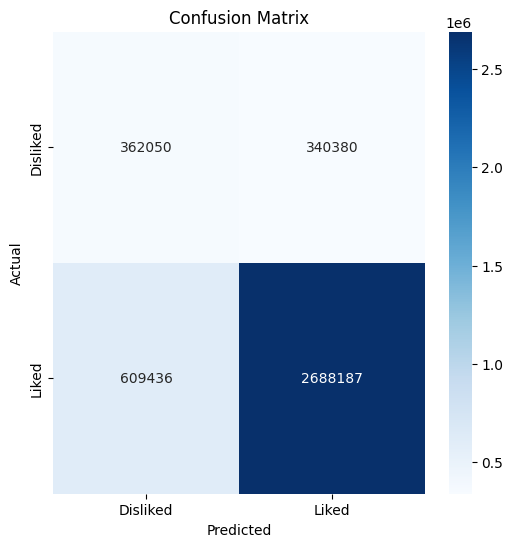

In [47]:
# Calculate and plot confusion matrix
cm = generate_confusion_matrix(test_loader)
plot_confusion_matrix(cm)

In [63]:
# Function to recommend N movies for a specific user
def recommend_movies(user_id, top_n=10):
    # Ensure user_id is in the training set
    if user_id not in user_id_lookup.values:
        return "User not in training set."
    
    user_idx = torch.tensor([user_id_lookup.get_loc(user_id)], dtype=torch.long).to(device)
    
    # Generate predicted ratings for all movies for this user
    movie_ids_tensor = torch.arange(num_movies).to(device)
    
    with torch.no_grad():
        predicted_ratings = model_loaded(user_idx.repeat(num_movies), movie_ids_tensor)
    
    # Convert predicted ratings to a numpy array
    predicted_ratings = predicted_ratings.cpu().numpy()
    
    # Get the top N recommended movies based on predicted ratings
    top_movie_indices = predicted_ratings.argsort()[-top_n:][::-1]
    
    # Map the movie indices back to the movie IDs using movie_id_lookup
    recommended_movie_ids = [movie_id_lookup[i] for i in top_movie_indices]
    
    return recommended_movie_ids


In [51]:
# Ensure the model is in evaluation mode
model_loaded.eval()




MatrixFactorization(
  (user_embedding): Embedding(138493, 128)
  (movie_embedding): Embedding(26744, 128)
)

In [64]:
def recommend_movies(user_id, top_n=10):
    # Ensure user_id is in the training set
    if user_id not in user_id_lookup.values:
        return "User not in training set."
    
    user_idx = torch.tensor([user_id_lookup.get_loc(user_id)], dtype=torch.long).to(device)
    
    # Generate predicted ratings for all movies for this user
    movie_ids_tensor = torch.arange(num_movies).to(device)
    
    with torch.no_grad():
        predicted_ratings = model_loaded(user_idx.repeat(num_movies), movie_ids_tensor)
    
    # Convert predicted ratings to a numpy array
    predicted_ratings = predicted_ratings.cpu().numpy()
    
    # Get the top N recommended movies based on predicted ratings
    top_movie_indices = predicted_ratings.argsort()[-top_n:][::-1]
    
    # Map the movie indices back to the movie IDs using movie_id_lookup
    recommended_movie_ids = [movie_id_lookup[i] for i in top_movie_indices]
    
    return recommended_movie_ids

In [67]:
ratings['user_index'], user_id_lookup = pd.factorize(ratings['userId'])
ratings['movie_index'], movie_id_lookup = pd.factorize(ratings['movieId'])


In [69]:
user_id = 1  # or some valid ID from your dataset
user_idx = torch.tensor([user_id_lookup.get_loc(user_id)], dtype=torch.long).to(device)


In [70]:
recommended_movies = recommend_movies(1, top_n=10)
print(recommended_movies)


[np.int64(113039), np.int64(64923), np.int64(99636), np.int64(98613), np.int64(87917), np.int64(118242), np.int64(90017), np.int64(27539), np.int64(26741), np.int64(82311)]
